# Analysis and Classification of Political Tweets

Previous research has shown that the outcome of a political campaign [correlates positively with the campaign’s social media interaction](https://doi.org/10.1371/journal.pone.0079449). The more “favorites” and “retweets” a campaign gets, the better the candidate does. In this sense, Twitter can be used as source for polling data. Analyzing the amount of interaction on Twitter might predict who will win the race.

So far, 2018's special elections, have not supported this theory. One possible reason is the outsized media attention paid to otherwise typically ignored races.

This project analyzes Twitter engagement of campaigns (favorites and retweets), as well as sentiment analysis, and finally uses the NLTK word tokenizer and TFIDF transformer, as well as Multinomial Naive Bayes and Support Vector Machine models to predict winning and losing campaigns. Text documents (tweets) from 10 campaigns for special elections were analyzed and compared to four upcoming campaigns to predict the outcome.

In [1]:
import sys
# These are commented out because they take a long time to load.
# If you run this notebook and it throws errors regarding these libraries
# uncomment these lines.
# !conda install --yes --prefix {sys.prefix} tweepy
# !conda install --yes --prefix {sys.prefix} textblob
# !conda install --yes --prefix {sys.prefix} twython

In [2]:
import nltk
# nltk.download('vader_lexicon')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import twitter_sent
from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.patches as mpatches
import copy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
%precision 2

'%.2f'

## Data

The Twitter timelines of 14 campaigns (10 already held and 4 upcoming) were extracted using my [Twitter sentiment analysis project](https://github.com/oxenfree/TwitterSentimentAnalysis). 500 tweets from each timeline were gathered: the tweet text, date and time of posting, as well as how many retweets and favorites were recorded to CSV file.

The text of each tweet was cleaned by regex, removing “@” and “#” symbols, as well as common Twitter artifacts such as “RT: “. This pre-processing removed possible stumbling-blocks to sentiment analysis.

Next the NLTK Sentiment Analyzer was used to add probabilities of sentiment to each text. Each text document can contain all three probabilities: positive, neutral, and negative. The probabilities (pos, neu, neg) were added to the dataframe.

In [4]:
# These lists are used throughout the code below, but are also good 
# reminders of which candidate is where, if they won, etc.
won = ['JimmyGomezCA', 'JamesThompsonKS', 'karenhandel', 'RalphNorman', 'GregForMontana']
lost = ['AhnforCA34', 'LauraforKansas', 'ossoff', 'Archie4Congress', 'RobQuistforMT']
upcoming = ['realScottWagner', 'WolfForPA', 'AndrewGillum', 'RonDeSantisFL']
pa = ['realScottWagner', 'WolfForPA']
fl = ['AndrewGillum', 'RonDeSantisFL']
ca = ['JimmyGomezCA', 'AhnforCA34']
ks = ['LauraforKansas', 'JamesThompsonKS']
ga = ['karenhandel', 'ossoff']
sc = ['RalphNorman', 'Archie4Congress']
mt = ['GregForMontana', 'RobQuistforMT']
all_file_names = ['GregForMontana', 'RobQuistforMT', 'RalphNorman', 'karenhandel', 'ossoff', 'Archie4Congress', 'LauraforKansas', 'JamesThompsonKS',
            'JimmyGomezCA', 'AhnforCA34', 'AndrewGillum', 'RonDeSantisFL', 'realScottWagner', 'WolfForPA']
all_states = [pa, fl, ca, ks, ga, sc, mt]

In [5]:
# Creating dataframes of all the candidates that were analyzed.

frames = {name: pd.read_csv(f'data/{name}.csv', low_memory=True) for name in all_file_names}
greg_mt = frames['GregForMontana']
rob_mt = frames['RobQuistforMT']
karen_ga = frames['karenhandel']
tom_ga = frames['ossoff']
ralph_sc = frames['RalphNorman']
archie_sc = frames['Archie4Congress']
laura_ks = frames['LauraforKansas']
james_ks = frames['JamesThompsonKS']
jimmy_ca = frames['JimmyGomezCA']
ahn_ca = frames['AhnforCA34']
andrew_fl = frames['AndrewGillum']
ron_fl = frames['RonDeSantisFL']
scott_pa = frames['realScottWagner']
tom_pa = frames['WolfForPA']

In [6]:
# Null check for all dataframes
# I ran this once for and there were no null values
# This is commented out just for efficiency.
# for k, v in frames.items():
#     display(f'{k}', frames[k].isna().sum())

In [7]:
# Check for shape
# All frames have 500 tweets.
# Commented for efficiency.
# for k, v in frames.items():
#     display(f'{k}', frames[k].shape)

### Creating "won" and "lost" dataframes

In [8]:
def extract_from_frame(list):
    retweets = []
    favorites = []
    
    def get_retweets_likes(name, value):
        return frames[name].loc[:, value].tolist()
    
    for name in list:
        retweets.extend(get_retweets_likes(name, 'retweet_count'))
        favorites.extend(get_retweets_likes(name, 'favorite_count'))
    
    return retweets, favorites

wr, wf = extract_from_frame(won)
lr, lf = extract_from_frame(lost)
win_data = {
    'retweets': wr,
    'favorites': wf
}
lost_data = {
    'retweets': lr,
    'favorites': lf
}
win_counts = pd.DataFrame(data=win_data)
loss_counts = pd.DataFrame(data=lost_data)
win_counts['win_loss'] = 'won'
loss_counts['win_loss'] = 'lost'
wl_counts = win_counts.merge(loss_counts, how='outer')
wl_long = pd.melt(wl_counts, 'win_loss', var_name='count')

## Analysis and Visualization of Favorites and Retweets

Previous research suggests that the number of likes and retweets each candidate receives can predict their success in the race. In 2018, this hasn't been the case. Most likely due to the outsized amount of national attention these smaller races have garnered. 

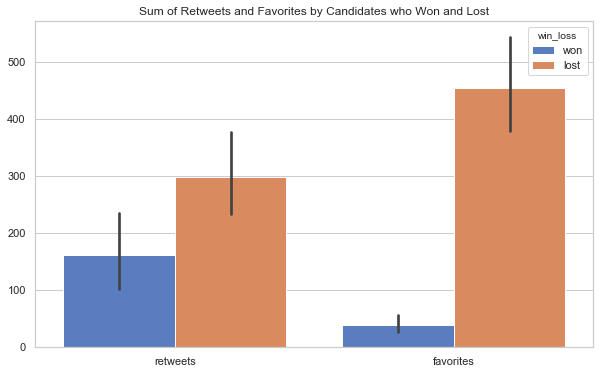

In [9]:
sns.set(rc={'figure.figsize':(10, 6)})
sns.set(style='whitegrid', palette='muted')
sns.barplot(x='count', y='value', hue='win_loss', data=wl_long)
plt.title('Sum of Retweets and Favorites by Candidates who Won and Lost')
plt.xlabel('')
plt.ylabel('')
plt.show()

You can see above that the number of retweets and favorites per candidate who lost outstrips the candidates who won. 

Below, we can look at the raw numbers.

In [10]:
print('\nWin counts shape:', win_counts.shape, 'Loss counts shape:', loss_counts.shape)
print('=' * 25)
print('\nWins Retweets:')
print('Max:', win_counts.retweets.max(), '| Avg:', win_counts.retweets.mean(), '| Sum:', win_counts.retweets.sum())
print('\nLosses Retweets:')
print('Max:', loss_counts.retweets.max(), '| Avg:', loss_counts.retweets.mean(), '| Sum:', loss_counts.retweets.sum())
print('=' * 25)
print('\nWins Favorites:')
print('Max:', win_counts.favorites.max(), '| Avg:', win_counts.favorites.mean(), '| Sum:', win_counts.favorites.sum())
print('\nLosses Favorites:')
print('Max:', loss_counts.favorites.max(), '| Avg:', loss_counts.favorites.mean(), '| Sum:', loss_counts.favorites.sum())
print('=' * 25)


Win counts shape: (2198, 3) Loss counts shape: (1985, 3)

Wins Retweets:
Max: 49376 | Avg: 160.95313921747044 | Sum: 353775

Losses Retweets:
Max: 37160 | Avg: 298.74609571788415 | Sum: 593011

Wins Favorites:
Max: 15125 | Avg: 38.43630573248408 | Sum: 84483

Losses Favorites:
Max: 33200 | Avg: 454.5324937027708 | Sum: 902247


### New Dataframes with Text
Creating a dataframe of all values (not just retweets and favorites), including the text of each tweet. We'll clean the text, run a sentiment analysis, and eventually tokenize, TFIDF transform, and build models against these texts.

In [11]:
lost_df = pd.concat([frames[name] for name in lost], ignore_index=True)
won_df = pd.concat([frames[name] for name in won], ignore_index=True)

In [12]:
sia = SentimentIntensityAnalyzer()
def clean_add_sents(frame_in):

    def add_nltk_sents(dict_in):
        count = 0
        while count < len(dict_in):
            probs = sia.polarity_scores(dict_in[count]['text'])
            dict_in[count]['nltk_pos'] = probs['pos']
            dict_in[count]['nltk_neg'] = probs['neg']
            dict_in[count]['nltk_neu'] = probs['neu']
            count += 1
        return dict_in
            
    frame = copy.deepcopy(frame_in)
    temp = frame.to_dict(orient='index')
    cleaned_temp = twitter_sent.TweetHandler.clean_tweet_map_texts(temp)
    sent_temp = add_nltk_sents(cleaned_temp)
    sent_temp = twitter_sent.TweetHandler.add_text_blob_sentiment_map(sent_temp)
    frame = pd.DataFrame().from_dict(sent_temp, orient='index')
    return frame

won_df = clean_add_sents(won_df)
lost_df = clean_add_sents(lost_df)

## Analysis and Visualization of Sentiment

Each Tweet from each candidate was then analyzed for sentiment. Density plots for negative and positive sentiment shows very little difference between candidates that won their race versus candidates that lost. A density plot is very similar to a histogram, the plot shows the distribution of negative sentiment per tweet text. Since the NLTK Sentiment Analyzer shows a probability for each sentiment, if winning or losing tweet texts were either more positive or negative, one of these plots would be shifted to the right. 

For example, if losing candidated tweeted negative sentiment more often, the distribution peak would be shifted further rightward along the x axis.

These plots show almost no difference in sentiment between those who have lost and those who have won.

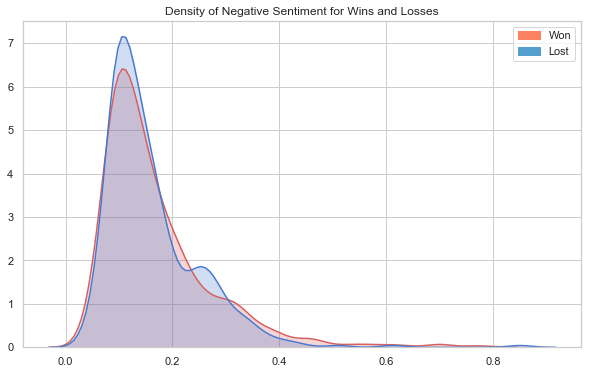

In [13]:
won_neg = won_df.loc[won_df['nltk_neg'] > 0]['nltk_neg']
lost_neg = lost_df.loc[lost_df['nltk_neg'] > 0]['nltk_neg']
p1 = sns.kdeplot(won_neg, shade=True, color='r')
p1 = sns.kdeplot(lost_neg, shade=True, color='b')
red_patch = mpatches.Patch(color=sns.color_palette('Reds')[2], label='Won')
blue_patch = mpatches.Patch(color=sns.color_palette('Blues')[3], label='Lost')
plt.legend(handles=[red_patch, blue_patch])
plt.title('Density of Negative Sentiment for Wins and Losses')
plt.show()

Above is the density plot for negative sentiment. 

The density plot for positive sentiment is below.

Notice there's not much difference to each plot per sentiment.

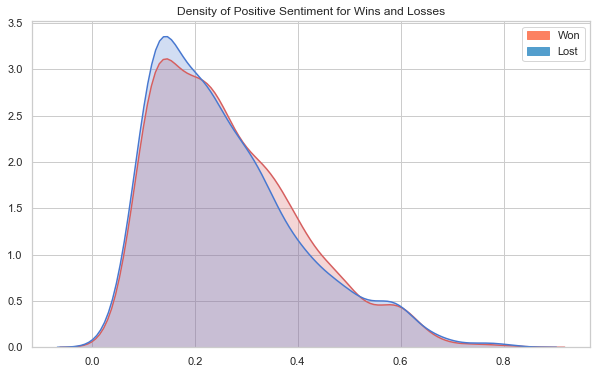

In [14]:
won_pos = won_df.loc[won_df['nltk_pos'] > 0]['nltk_pos']
lost_pos = lost_df.loc[lost_df['nltk_pos'] > 0]['nltk_pos']
p1 = sns.kdeplot(won_pos, shade=True, color='r')
p1 = sns.kdeplot(lost_pos, shade=True, color='b')
red_patch = mpatches.Patch(color=sns.color_palette('Reds')[2], label='Won')
blue_patch = mpatches.Patch(color=sns.color_palette('Blues')[3], label='Lost')
plt.legend(handles=[red_patch, blue_patch])
plt.title('Density of Positive Sentiment for Wins and Losses')
plt.show()

In [15]:
ca_df = pd.concat([frames[name] for name in ca], ignore_index=True)
ks_df = pd.concat([frames[name] for name in ks], ignore_index=True)
ga_df = pd.concat([frames[name] for name in ga], ignore_index=True)
sc_df = pd.concat([frames[name] for name in sc], ignore_index=True)
mt_df = pd.concat([frames[name] for name in mt], ignore_index=True)

### Density Plot by State

Just to visualize some more sentiment by density plot, here's one for positive sentiment per state.

In [16]:
# Making frames per state
ca_df = clean_add_sents(ca_df)
ks_df = clean_add_sents(ks_df)
ga_df = clean_add_sents(ga_df)
sc_df = clean_add_sents(sc_df)
mt_df = clean_add_sents(mt_df)

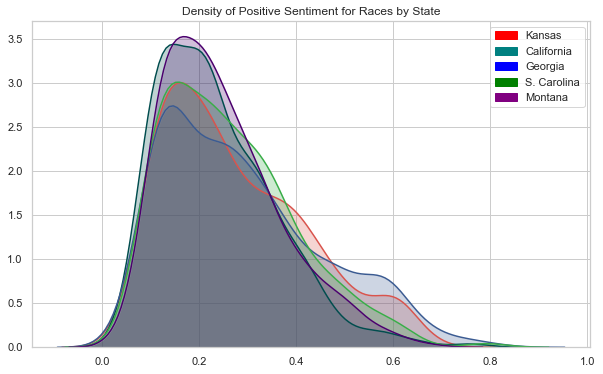

In [17]:
colors = {
    'red': [ks_df, sns.xkcd_rgb['pale red'], 'Kansas'],
    'teal': [ca_df, sns.xkcd_rgb['dark teal'], 'California'],
    'blue': [ga_df, sns.xkcd_rgb['denim blue'], 'Georgia'],
    'green': [sc_df, sns.xkcd_rgb['medium green'], 'S. Carolina'],
    'purple': [mt_df, sns.xkcd_rgb['royal purple'], 'Montana'],
}
handles = []
for k, v in colors.items():
    sns.kdeplot(v[0].loc[v[0]['nltk_pos'] > 0]['nltk_pos'], color=v[1], shade=True)
    handles.append(mpatches.Patch(color=k, label=v[2]))
plt.legend(handles=[handle for handle in handles])
plt.title('Density of Positive Sentiment for Races by State')
plt.show()

### Adding a classification and label

We'll add "1" as a winning classification with the label "w" and "0" as the losing classification with label "l" (lowercase letter L).

In [18]:
won_df['win_loss'] = 1
won_df['label'] = 'w'
lost_df['win_loss'] = 0
lost_df['label'] = 'l'
wl_df = won_df.merge(lost_df, how='outer')

## Classifying Campaign Outcome by Text Analysis
### Training and Testing on previously-held races

Two machine learning models were created and trained on the “won” and “lost” dataframes, using the cleaned tweet texts. First, pipelines were built for the Multinomial Naïve Bayes and Support Vector Machine (SVM) algorithms. The pipelines used the NTLK Count Vectorizer and the TFIDF Transformer. Parameters for the algorithms such as ngram range, whether to use stop words or not, and “min df” (minimum number of word matches to add to the TFIDF transformer) were then fed into the pipelines using the Grid Search Cross Validation with a cross-validation parameter set to “3”.

The Grid Search Cross Validation then chooses the best set of parameters to use when fitting the model to the training data. The best model for both SVM and MNB, predicted the class as either 1 (won) or 0 (lost) at an overall accuracy of around 80%. Multinomial Naïve Bayes performed slightly better with recall of the 0 (losing) class, while SVM performed slightly better with precision of the 1 (winning) class.


In [19]:
scoring = {'Precision': make_scorer(precision_score), 'Accuracy': make_scorer(accuracy_score)}
mnb_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])
svm_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=100))
])
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'vect__min_df': (1, 2, 3),
    'vect__stop_words': ('english', None),
    'vect__encoding': ('latin1', 'utf8'),
    'tfidf__use_idf': (True, False),
}
alphas = {
    'SVM': (1.0000000000000001e-05, 9.9999999999999995e-07),
    'MNB': (.1, .5, .75, 1)
}
train_X, test_X, train_y, test_y = train_test_split(wl_df['text'].values, wl_df['win_loss'].values, test_size=0.3, random_state=123)

In [20]:
clfs = {}
def run_grid_score(pipeline, name):
    parameters['clf__alpha'] = alphas[name]
    clf = GridSearchCV(
        pipeline, 
        parameters,
        n_jobs=-1,
        scoring=scoring,
        cv=3,
        refit='Accuracy'
    )
    clf.fit(train_X, train_y)
    clfs[name] = clf
    print('#' * 50)
    print(f'\n{name} training set best score:', clf.best_score_, '\n')
    print('Training set best parameters:')
    display(clf.best_params_)
    print(f'Detailed classification report for {name} test set:')
    pred = clf.predict(test_X)
    print(classification_report(test_y, pred))
    print(f'Confustion Matrix for {name} test set:')
    display(confusion_matrix(test_y, pred))
run_grid_score(svm_pipe, 'SVM')
run_grid_score(mnb_pipe, 'MNB')

##################################################

SVM training set best score: 0.805327868852459 

Training set best parameters:


{'clf__alpha': 0.00,
 'tfidf__use_idf': True,
 'vect__encoding': 'utf8',
 'vect__min_df': 1,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

Detailed classification report for SVM test set:
             precision    recall  f1-score   support

          0       0.79      0.81      0.80       602
          1       0.82      0.81      0.81       653

avg / total       0.81      0.81      0.81      1255

Confustion Matrix for SVM test set:


array([[489, 113],
       [127, 526]])

##################################################

MNB training set best score: 0.8128415300546448 

Training set best parameters:


{'clf__alpha': 0.50,
 'tfidf__use_idf': False,
 'vect__encoding': 'latin1',
 'vect__min_df': 1,
 'vect__ngram_range': (1, 3),
 'vect__stop_words': 'english'}

Detailed classification report for MNB test set:
             precision    recall  f1-score   support

          0       0.85      0.75      0.80       602
          1       0.79      0.88      0.83       653

avg / total       0.82      0.82      0.82      1255

Confustion Matrix for MNB test set:


array([[452, 150],
       [ 78, 575]])

### Examining the Classifiers

We can look at the internal attributes of the best fit for each pipeline. Below we can see the head of a quick DataFrame made from the Multinomial Naïve Bayes CountVectorizer's vocabulary. Admittedly, the cleaning of texts could be improved: note the "https" as one of the words in the vocab.

In [21]:
pd.DataFrame.from_dict(
    clfs['MNB'].best_estimator_.get_params()['vect'].vocabulary_, 
    columns=['count'],
    orient='index'
).head()

count
honor     21540
billings   5603
vp        51523
mtpol     32990
https     22017

In [22]:
def predict_upcoming(pipeline, model_name, upcoming_name, upcoming_X):
    print(f'Predicting upcoming race for {upcoming_name} with {model_name}')
    return pipeline.predict(upcoming_X)

In [23]:
upcoming_dfs = {
    'Andrew Gillum, FL Gov': {'df': andrew_fl},
    'Ron De Santis, FL Gov': {'df': ron_fl},
    'Scott Wagner, PA Gov': {'df': scott_pa},
    'Tom Wolf, PA Gov': {'df': tom_pa},
}

### Training on previously-run races and predicting upcoming races

The same pipeline and cross-validation process and training data can be used to fit these models again. Instead of testing against a hold-out subset of training data, the tweet texts for upcoming elections was used. Since the label “won” corresponds with the class “1”, a prediction was made by simply summing the number of tweets with “winning” type texts. 

In [24]:
for name, nested in upcoming_dfs.items():
    temp_frame = clean_add_sents(nested['df'])
    preds = {
        'svm_pred': predict_upcoming(clfs['SVM'], 'SVM', name, temp_frame['text'].values),
        'mnb_pred': predict_upcoming(clfs['MNB'], 'MNB', name, temp_frame['text'].values)
    }
    nested['preds'] = preds
    nested['cleaned_df'] = temp_frame
print('\n Classification done.')

Predicting upcoming race for Andrew Gillum, FL Gov with SVM
Predicting upcoming race for Andrew Gillum, FL Gov with MNB
Predicting upcoming race for Ron De Santis, FL Gov with SVM
Predicting upcoming race for Ron De Santis, FL Gov with MNB
Predicting upcoming race for Scott Wagner, PA Gov with SVM
Predicting upcoming race for Scott Wagner, PA Gov with MNB
Predicting upcoming race for Tom Wolf, PA Gov with SVM
Predicting upcoming race for Tom Wolf, PA Gov with MNB

 Classification done.


### Simply summing the classifications

Since the tweets which are labeled as "winning" tweets have a classification of "1", we can sum each candidates total to get a prediction.

In [25]:
for name, nested in upcoming_dfs.items():
    print('\n', '#' * 50, '\n')
    print(f'Sum for {name}, MNB Predictions:', nested['preds']['mnb_pred'].sum())
    nested['cleaned_df'] = nested['cleaned_df'].assign(mnb_pred=nested['preds']['mnb_pred'])
    print(f'Sum for {name}, SVM Predictions:', nested['preds']['svm_pred'].sum())
    nested['cleaned_df'] = nested['cleaned_df'].assign(svm_pred=nested['preds']['svm_pred'])
print('\n', '#' * 50, '\n')


 ################################################## 

Sum for Andrew Gillum, FL Gov, MNB Predictions: 270
Sum for Andrew Gillum, FL Gov, SVM Predictions: 232

 ################################################## 

Sum for Ron De Santis, FL Gov, MNB Predictions: 395
Sum for Ron De Santis, FL Gov, SVM Predictions: 322

 ################################################## 

Sum for Scott Wagner, PA Gov, MNB Predictions: 397
Sum for Scott Wagner, PA Gov, SVM Predictions: 348

 ################################################## 

Sum for Tom Wolf, PA Gov, MNB Predictions: 336
Sum for Tom Wolf, PA Gov, SVM Predictions: 272

 ################################################## 



### Extracting the predictions and graphing

In [26]:
tom_clean_predicted = upcoming_dfs['Tom Wolf, PA Gov']['cleaned_df']
scott_clean_predicted = upcoming_dfs['Scott Wagner, PA Gov']['cleaned_df']
ron_clean_predicted = upcoming_dfs['Ron De Santis, FL Gov']['cleaned_df']
andrew_clean_predicted = upcoming_dfs['Andrew Gillum, FL Gov']['cleaned_df']

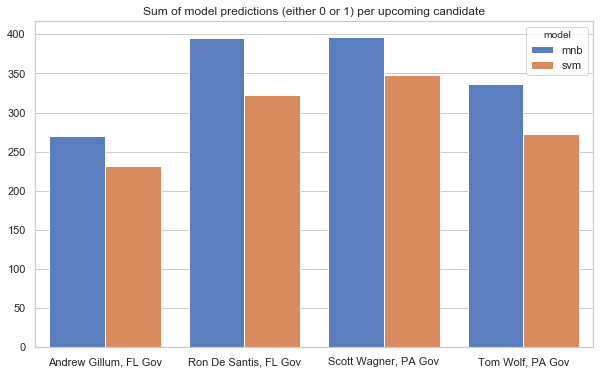

In [27]:
mnb_pred_sums = {}
svm_pred_sums = {}
for name, nested in upcoming_dfs.items():
    mnb_pred_sums[name] = nested['cleaned_df'].loc[:, 'mnb_pred'].sum()
    svm_pred_sums[name] = nested['cleaned_df'].loc[:, 'svm_pred'].sum()
    
svm_df = pd.DataFrame(columns=['candidate', 'svm_sum']).from_records(svm_pred_sums, index=[0])
mnb_df = pd.DataFrame(columns=['candidate', 'mnb_sum']).from_records(mnb_pred_sums, index=[0])
melted_svm = pd.melt(svm_df, var_name='candidate')
melted_svm['model'] = 'svm'
melted_mnb = pd.melt(mnb_df, var_name='candidate')
melted_mnb['model'] = 'mnb'
melt_all = melted_mnb.merge(melted_svm, how='outer')

sns.set(rc={'figure.figsize':(10, 6)})
sns.set(style='whitegrid', palette='muted')
sns.barplot(x='candidate', y='value', hue='model', data=melt_all)
plt.title('Sum of model predictions (either 0 or 1) per upcoming candidate')
plt.xlabel('')
plt.ylabel('')
plt.show()

## Conclusion

A small subset of election campaign tweets, only special elections held in a politically atypical year, showed that twitter interaction (favorites and retweets) did not predict well the outcome of these elections. Similarly, analysis of sentiment, using NLTK Sentiment Analyzer, showed very little difference between winning and losing campaigns. 

Using a word tokenizer and TFIDF transformer showed that machine learning models could accurately predict the classification of “winning” and “losing” campaigns based on text analysis. These models could then predict upcoming elections. 

However, this analysis is just another resource for campaign and political prediction. Like polls and pundit analysis, all predictions are likely to be wrong. For example, Tom Wolf is the current governor of Pennsylvania. He has the advantage of incumbency and he has been [polling much better than Scott Wagner](https://realclearpolitics.com/epolls/2018/governor/pa/pennsylvania_governor_wagner_vs_wolf-6542.html). It is unlikely that Wagner will overturn Wolf in November’s elections. Combined with other sources, this text analysis can likely be a good tool for political predictions.
